Сначала необходимо посмотреть на первоначальный датасет и, при необходимости, преобразовать его

In [1]:
import pandas as pd
from scripts.EDA import Location as location, DateFraud as datefraud, Transaction as transaction, df, reshapeDataFrame
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

df.head()

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0


Теперь надо его преобразовать, а именно, удалить столбцы TransactionID, тк прямого отношения к факту 
мошеннической операции она не имеет (по факту, это просто столбец с индексами строк + 1, тогда как MerchantID - категориальный признак),
но при этом будут вести к переобучению модели в будущем. Также я считаю, что нужно разбить колонку TransactionDate на колонки с датой (TransactionDate),
днем недели (DayOfWeek), часом (TransactionTime), имеет прямое отношение именно час, тк минуты и секунды слишком малы в рамках суток, чтобы иметь
существенное значение в рамках факта мошеннической операции, но при этом будут вести к переобучению модели в будущем

In [2]:
df = reshapeDataFrame(df)

df.head()


,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud,TransactionTime,TransactionMonth,DayOfWeek
0,3,4189.27,688,refund,San Antonio,0,14,4,2
1,19,2659.71,109,refund,Dallas,0,13,3,1
2,8,784.00,394,purchase,New York,0,10,1,0
3,13,3514.40,944,purchase,Philadelphia,0,23,4,5
4,12,369.07,475,purchase,Phoenix,0,18,7,4


Теперь можно составить список вопросов, основываясь на которых можно будет сделат какой-то вывод, касательно датасета и того, какие факторы влияют на факт
мошеннической операции
Для начала я посмотрю на то, как коррелируют между собой штат и количество мошеннических операций

<Axes: xlabel='Location'>

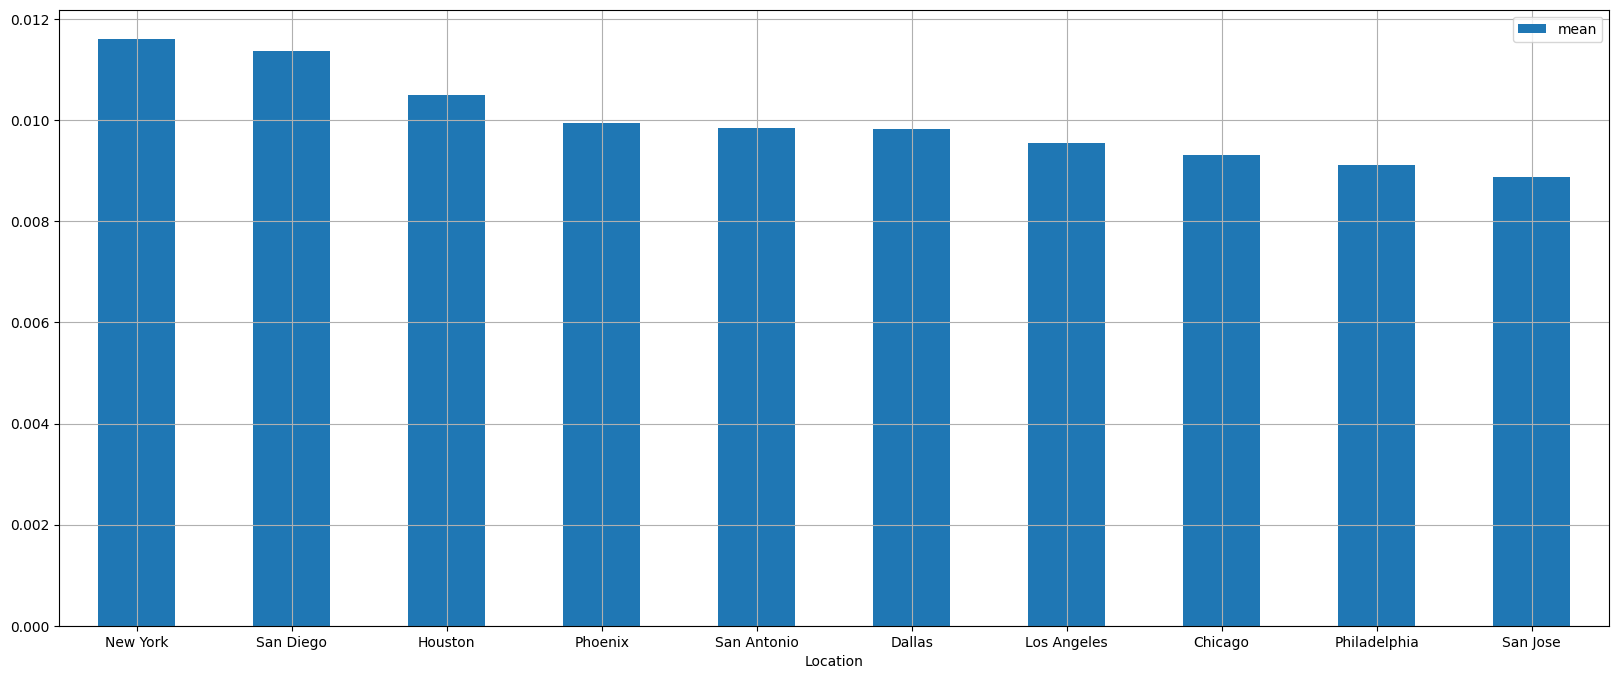

In [3]:
"""TO SEE THE SOURCE CODE CHECK scripts.EDA file"""

location.fraudLocation(df=df)


Итак, исходя из графика, можно сказать, что штат оказывает существенное на это влияние на факт мошенничества, но теперь есть мысли на сильный дисбаланс классов
необходимо проверить это

In [4]:
df['IsFraud'].value_counts()


IsFraud
0    99000
1     1000
Name: count, dtype: int64

Теперь виден огромный дисбаланс классов, но перед тем как с ним разобраться, надо дальше проверить корреляции
Следуюший вопрос: как коррелируют между собой время суток и количество мошеннических операций
Потому что вполне вполне возможен тот факт, что большинство мошеннических операций проводятся вечером

<Axes: xlabel='TransactionTime'>

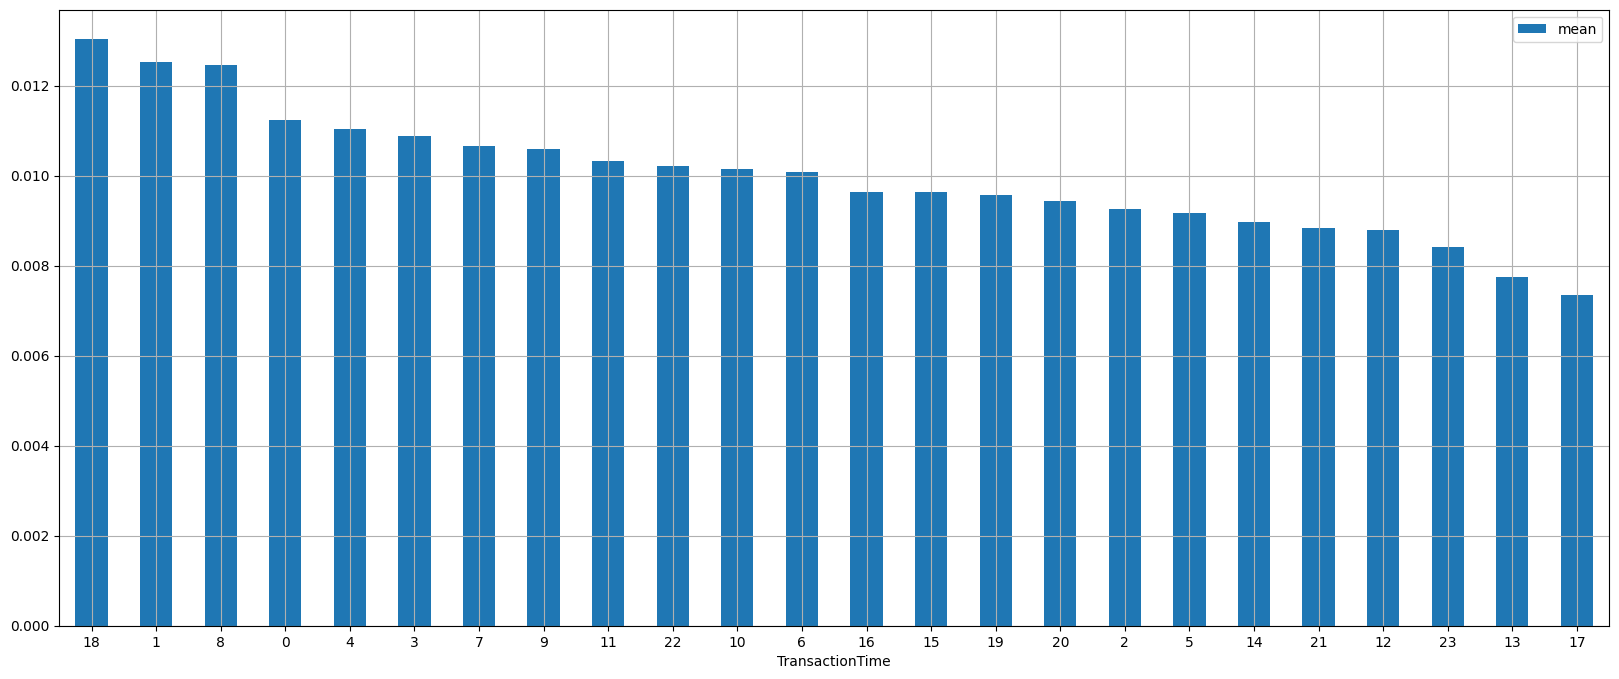

In [5]:
datefraud.daytime(df=df)


Из этого графика видно, что время суток также оказывает существенное влияние на количество мошеннических операций: 
Наибольшее количество, с весьма большим отрывом, забирают 6 вечера, 1 час ночи, 8 утра, 12 ночи, 4 утра
Далее из графика и топа 5 видно, что большинство мошеннических операций проводятся в часы, когда люди наиболее плохо соображают (за некоторым исключением)
Теперь имеет смысл посмотреть на эту же корреляцию, но в зависимости от дня недели

<Axes: xlabel='DayOfWeek'>

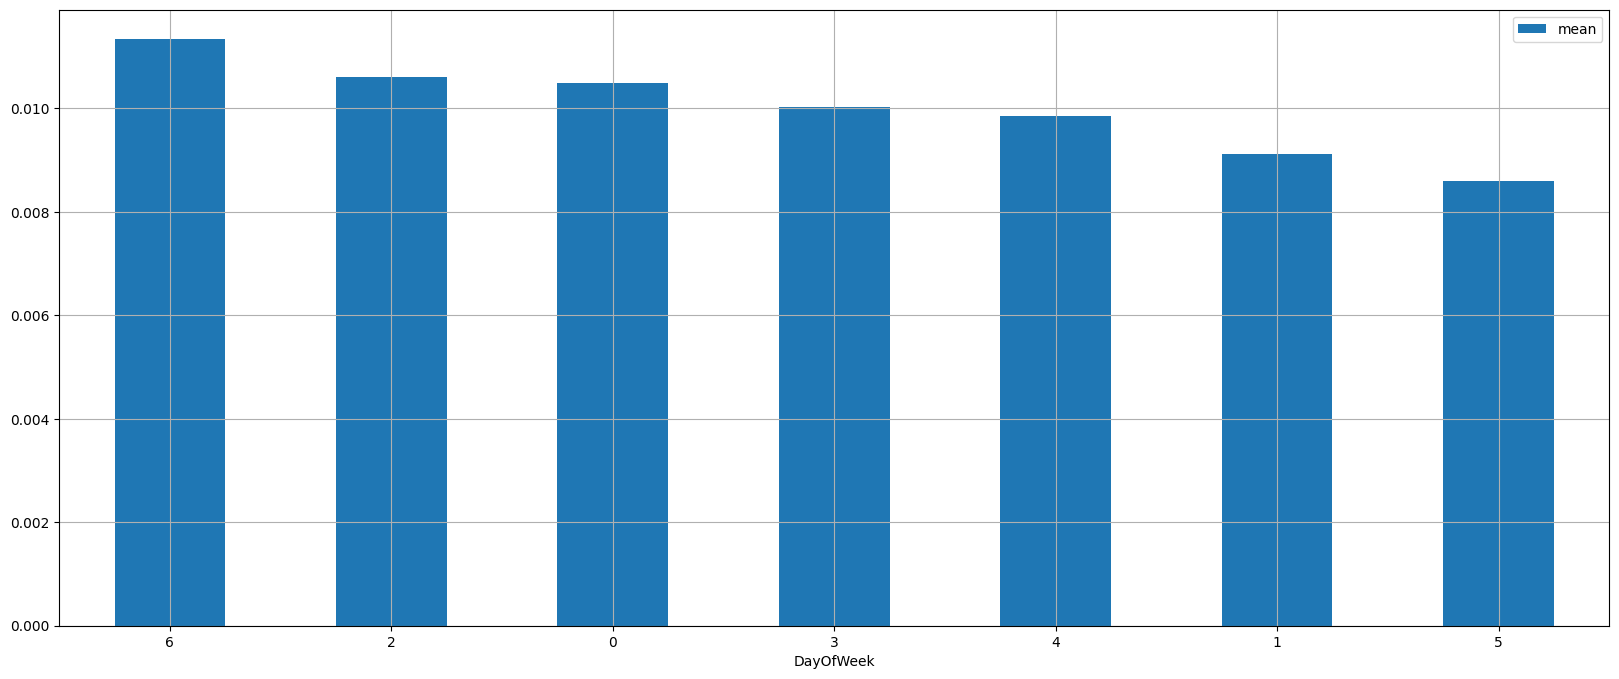

In [6]:
datefraud.weekday(df=df)


Из этого графика хорошо видно, что день недели также влияет на количество мошеннических операций, самое большое количество - воскресенье, 
самое маленькое - суббота, но в остальном. чем ближе к выходным. тем выше количество операций растет
Теперь посмотрим на медианное значение трат в зависимости от типы операции (возврат / покупка), тк в теории, если деньги будут отмывать, то скорее будут делать
возрат

<Axes: xlabel='TransactionType'>

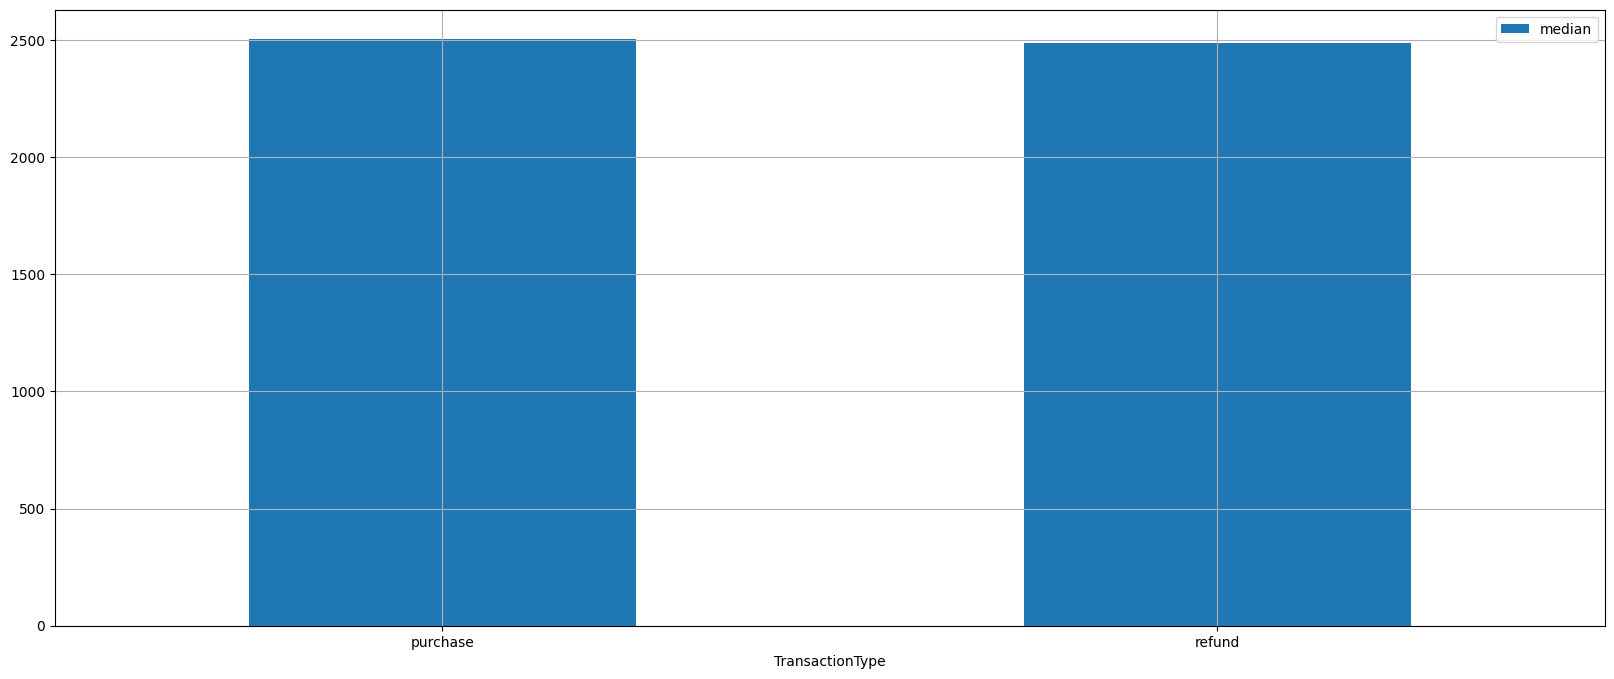

In [7]:
transaction.amount(df=df)


Отсюда видно, что медианное (среднее и дисперсия также примерно равны) значение суммы операции не зависит от типа операции, 
но также имеет смысл посмотреть на количество каждого из типов операции и
количества мошеннических операций

<Axes: xlabel='TransactionType'>

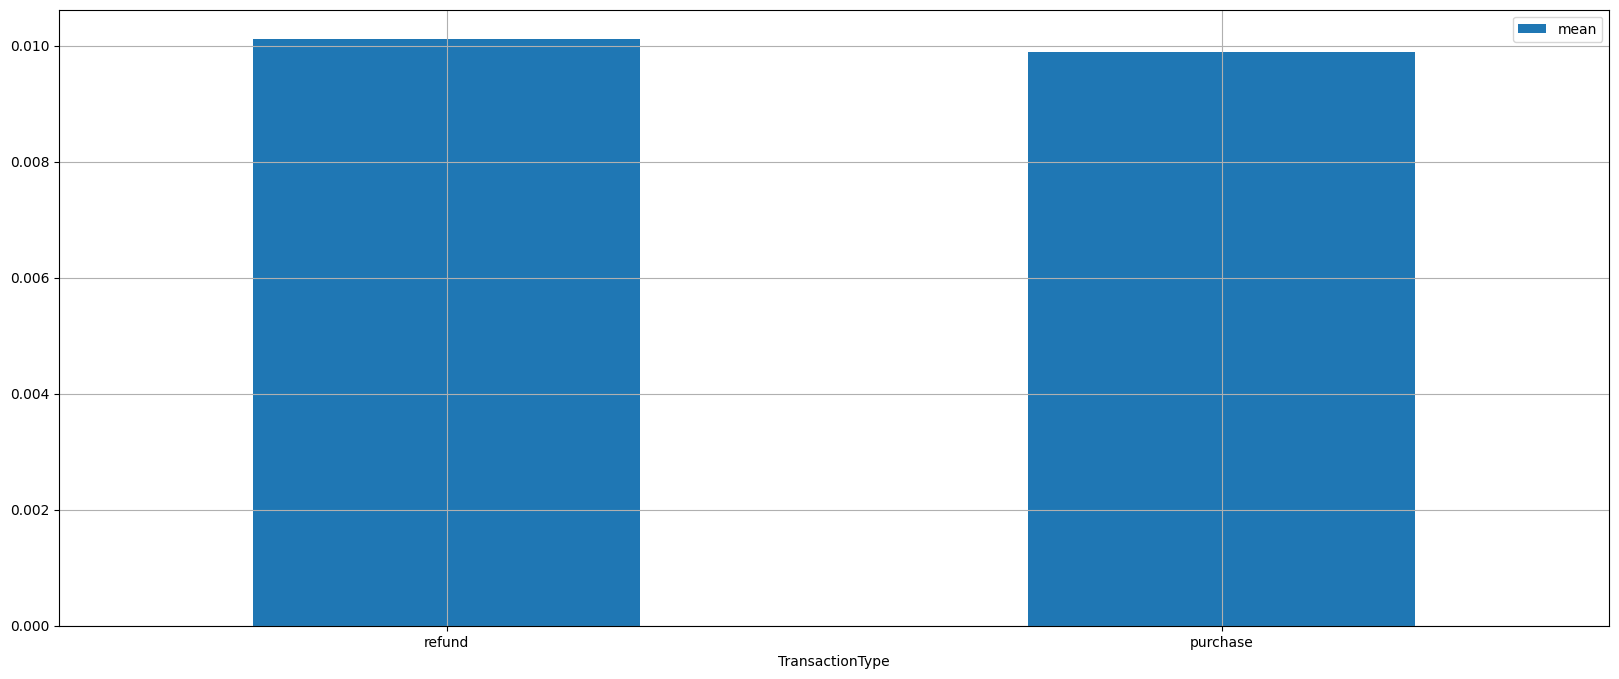

In [8]:
transaction.transactionType(df=df)


Отталкиваясь от графика видно, что количество мошеннических операций при возврате больше, но при этом и самих возвратов тоже больше, поэтому имеет смысл
посмотреть на среднее количество мошеннических операций в зависимости от типа операции